In [85]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# set up and get the main data 
# get all the tables from the wikipedia page 'https://en.wikipedia.org/wiki/Nasdaq-100#Components' and write them to a pandas dataframe called WikipediaDTs
nasdaq = 'https://en.wikipedia.org/wiki/Nasdaq-100#Components'
WikipediaDTs = pd.DataFrame()
WikipediaDTs = pd.read_html(nasdaq)
len(WikipediaDTs) # this will tell us how many tables there are on the page
tickersLIST = WikipediaDTs[4]['Ticker'].tolist()
#download from yahoo finance the historical data for all tickers in the list and put it in a single dataframe called hPricesDT
hPricesDT = pd.DataFrame()
hPricesDT = yf.download(tickersLIST, start='2010-07-01', end='2021-06-30')['Adj Close']

# identify any tickers with NaN values and list them in a list called tickersNaN
tickersNaN = []
for ticker in tickersLIST:
    if hPricesDT[ticker].isnull().values.any() == True:
        tickersNaN.append(ticker)
hPricesDT.drop(tickersNaN, axis=1, inplace=True) # drop the tickers with NaN values from the dataframe hPricesDT



[*********************100%%**********************]  101 of 101 completed


3 Failed downloads:
['GEHC', 'CEG', 'GFS']: Exception("%ticker%: Data doesn't exist for startDate = 1277956800, endDate = 1625025600")


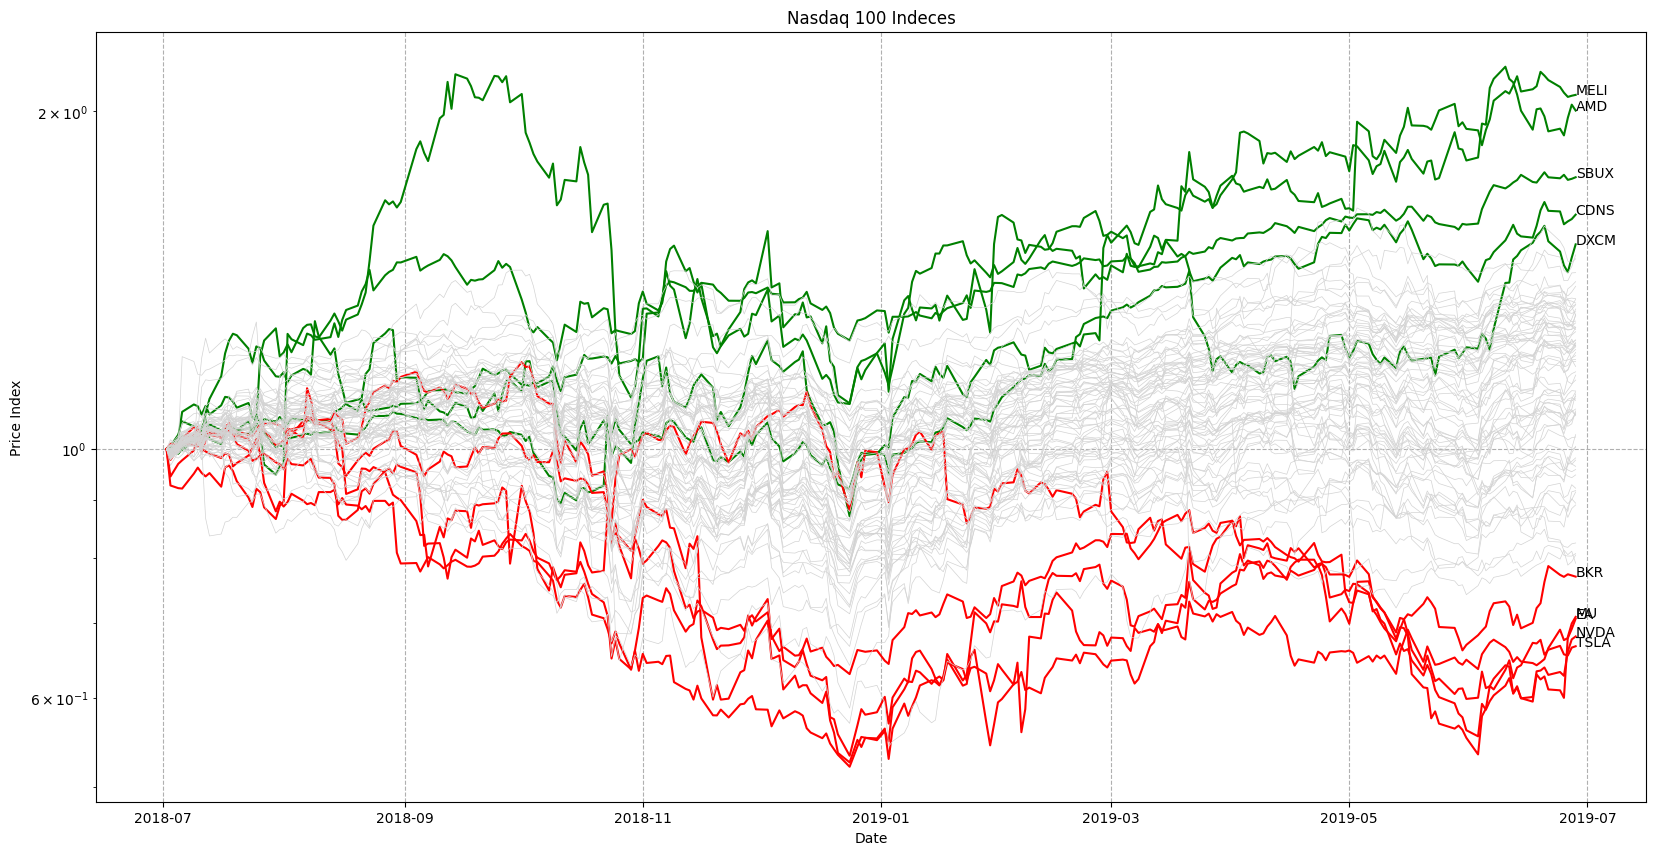

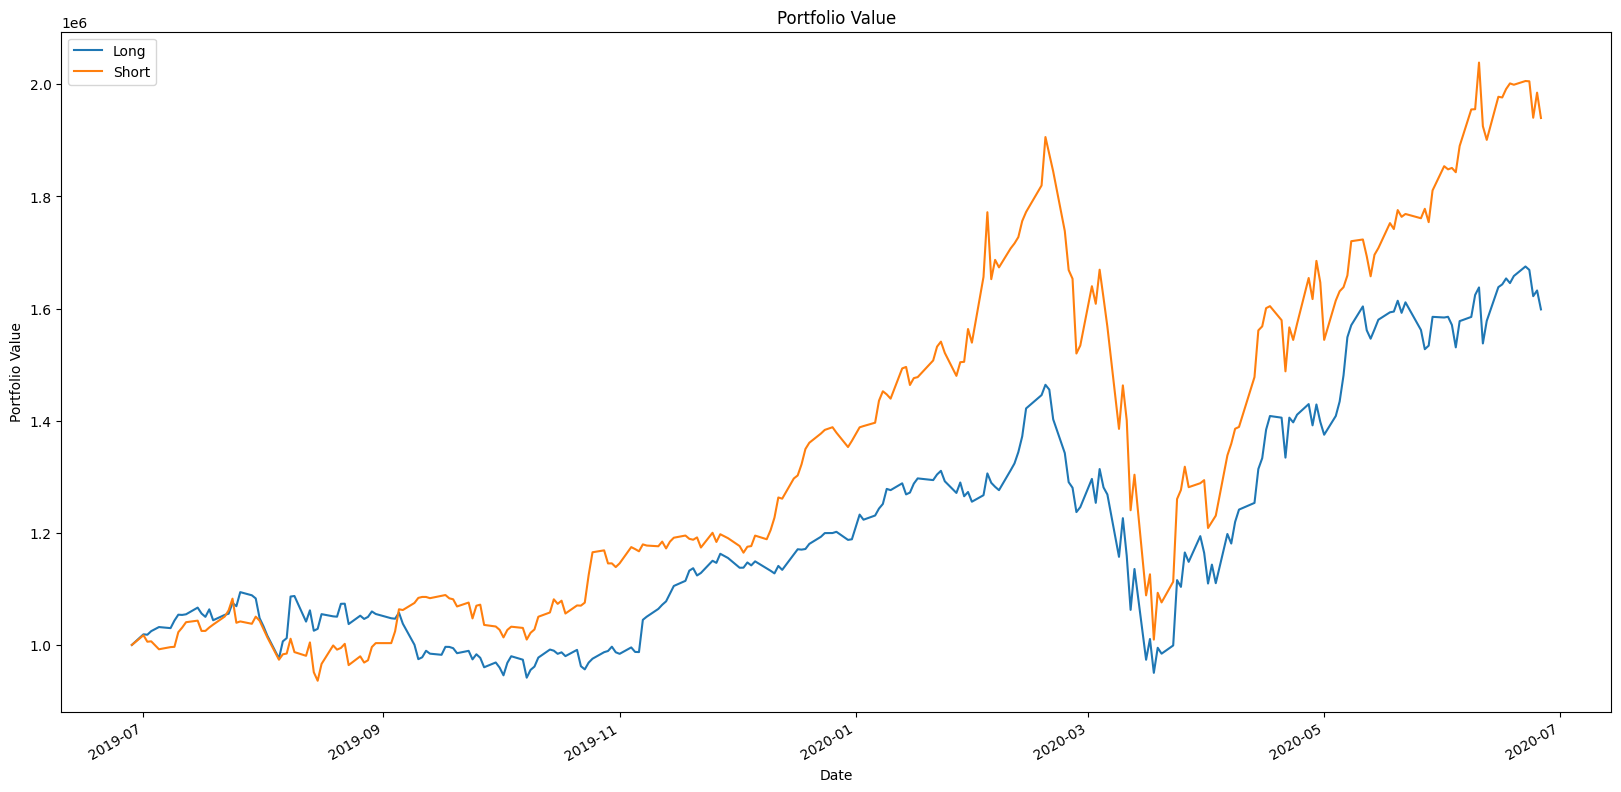

In [86]:
# set signal period and convert to timestamps
signal_start_date = '2018-07-01'
signal_start_date = pd.Timestamp(signal_start_date)
signal_end_date = signal_start_date + pd.DateOffset(years=1) + pd.DateOffset(days=-1)

# create a dataframe called signalDT that contains the prices for the signal period
signalDT = pd.DataFrame()
signalDT = hPricesDT[signal_start_date:signal_end_date]
# convert the prices to index values and put them in a dataframe called signalIndexDT
signalIndexDT = pd.DataFrame()
signalIndexDT = signalDT / signalDT.iloc[0]
# reset the signal dates to the first and last dates in the signalIndexDT dataframe index (noting that holidays and weekends will be skipped)
signal_start_date = signalIndexDT.index[0]
signal_end_date = signalIndexDT.index[-1]

# create a list of the 5 tickers and bottom 5 tickers with the highest index numbers at the end of the period
top5 = signalIndexDT.iloc[-1].nlargest(5).index.tolist()
bottom5 = signalIndexDT.iloc[-1].nsmallest(5).index.tolist()
otherTickers = signalIndexDT.columns.tolist()
for ticker in top5:
    otherTickers.remove(ticker)
for ticker in bottom5:
    otherTickers.remove(ticker)

# plot the index for all tickers in the dataframe hPricesIDX
plt.figure(figsize=(20,10))
for ticker in top5:
    plt.plot(signalIndexDT[ticker], color='green')
    plt.text(signalIndexDT.index[-1], signalIndexDT[ticker].iloc[-1], ticker)
for ticker in bottom5:
    plt.plot(signalIndexDT[ticker], color='red')
    plt.text(signalIndexDT.index[-1], signalIndexDT[ticker].iloc[-1], ticker)
for ticker in otherTickers:
    plt.plot(signalIndexDT[ticker], color='lightgrey', linewidth='0.5')
plt.xlabel('Date')
plt.ylabel('Price Index')
plt.title('Nasdaq 100 Indeces')
# use a log scale for the y axis
plt.yscale('log')
# plot gridlines
plt.grid(which='major', axis='both', linestyle='--')
plt.show()

#set up long and short portfolios
opening_portfolio_value = 1000000
# create a list of the prices in hPricesDT for top5
top5Prices = []
top5Prices = signalDT.iloc[-1][top5].tolist()
# set top5Weights to be the portfolio size divided by the prices in top5Prices
top5shareCount = []
top5shareCount = opening_portfolio_value / 5 / np.array(top5Prices)
longPORTinput = {'Ticker': top5, 'Price': top5Prices, 'ShareCount': top5shareCount}
longPORT = pd.DataFrame(longPORTinput)
longPORT.set_index('Ticker', inplace=True)  # set the index of longPORT to be the tickers
# set up the short portfolio
bottom5Prices = []
bottom5Prices = signalDT.iloc[-1][bottom5].tolist()
bottom5shareCount = []
bottom5shareCount = opening_portfolio_value / 5 / np.array(bottom5Prices)
shortPORTinput = {'Ticker': bottom5, 'Price': bottom5Prices, 'ShareCount': bottom5shareCount}
shortPORT = pd.DataFrame(shortPORTinput)
shortPORT.set_index('Ticker', inplace=True)

# look at performance of the long and short portfolios
trading_start_date = signal_end_date
trading_end_date = trading_start_date + pd.DateOffset(years=1) # set trading_end_date to be 1 year after trading_start_date
longPORT_values = hPricesDT[trading_start_date:trading_end_date][top5]*longPORT['ShareCount']
shortPORT_values = hPricesDT[trading_start_date:trading_end_date][bottom5]*shortPORT['ShareCount']
#chart the performance of the long and short portfolios
longPORT_values['Total'] = longPORT_values.sum(axis=1)
shortPORT_values['Total'] = shortPORT_values.sum(axis=1)
longPORT_values['Total'].plot(figsize=(20,10))
shortPORT_values['Total'].plot(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value')
plt.legend(['Long', 'Short'])

Now we want to convert some of the working parts of the program into functions so that we can repeatedly call them and produce output

The functions we need are:
1.  Find and build momentum portfolios
2.  Plot signal period
3.  Plot portfolio performance

In [87]:
def get_signal_data(hPricesDT, signal_start_date, signal_months):
    # convert signal_start_date to a timestamp
    signal_start_date = pd.Timestamp(signal_start_date)
    
    # calculate signal_end_date as 1 year after signal_start_date
    signal_end_date = signal_start_date + pd.DateOffset(months=signal_months) + pd.DateOffset(days=-1)

    # create a dataframe called signalDT that contains the prices for the signal period
    signalDT = hPricesDT[signal_start_date:signal_end_date]

    # convert the prices to index values and put them in a dataframe called signalIndexDT
    signalIndexDT = signalDT / signalDT.iloc[0]

    # reset the signal dates to the first and last dates in the signalIndexDT dataframe index (noting that holidays and weekends will be skipped)
    signal_start_date = signalIndexDT.index[0]
    signal_end_date = signalIndexDT.index[-1]

    return signalDT, signalIndexDT, signal_start_date, signal_end_date


In [88]:
def get_top_bottom_tickers(signalDT, signalIndexDT, numPositions):
    
    # create a list of the top performing tickers and bottom performing tickers with the highest index numbers at the end of the period
    topPerformers = signalIndexDT.iloc[-1].nlargest(numPositions).index.tolist()
    bottomPerformers = signalIndexDT.iloc[-1].nsmallest(numPositions).index.tolist()
    otherTickers = signalIndexDT.columns.tolist()
    for ticker in topPerformers:
        otherTickers.remove(ticker)
    for ticker in bottomPerformers:
        otherTickers.remove(ticker)
    
    return topPerformers, bottomPerformers, otherTickers

In [89]:
def plot_signal_period(hPricesIDX, topPerformers, bottomPerformers, otherTickers):
    # create a dataframe called signalIndexDT that contains the index values for all tickers
    signalIndexDT = hPricesIDX / hPricesIDX.iloc[0]

    # plot the index for all tickers in the dataframe signalIndexDT
    plt.figure(figsize=(20,10))
    for ticker in topPerformers:
        plt.plot(signalIndexDT[ticker], color='green')
        plt.text(signalIndexDT.index[-1], signalIndexDT[ticker].iloc[-1], ticker)
    for ticker in bottomPerformers:
        plt.plot(signalIndexDT[ticker], color='red')
        plt.text(signalIndexDT.index[-1], signalIndexDT[ticker].iloc[-1], ticker)
    for ticker in otherTickers:
        plt.plot(signalIndexDT[ticker], color='lightgrey', linewidth='0.5')
    plt.xlabel('Date')
    plt.ylabel('Price Index')
    plt.title('Nasdaq 100 Indices')
    # use a log scale for the y axis
    plt.yscale('log')
    # plot gridlines
    plt.grid(which='major', axis='both', linestyle='--')
    plt.show()

In [90]:
def get_long_short_portfolios(signatDT, signal_start_date, opening_portfolio_value, topPerformers, bottomPerformers, numPositions):

    # create a dataframe called longPORT that contains the long portfolio
    topPrices = signalDT.iloc[-1][topPerformers].tolist()
    topshareCount = opening_portfolio_value / numPositions / np.array(topPrices)
    longPORTinput = {'Ticker': topPerformers, 'Price': topPrices, 'ShareCount': topshareCount}
    longPORT = pd.DataFrame(longPORTinput)
    longPORT.set_index('Ticker', inplace=True)

    # create a dataframe called shortPORT that contains the short portfolio
    bottomPrices = signalDT.iloc[-1][bottomPerformers].tolist()
    bottomshareCount = opening_portfolio_value / numPositions / np.array(bottomPrices)
    shortPORTinput = {'Ticker': bottomPerformers, 'Price': bottomPrices, 'ShareCount': bottomshareCount}
    shortPORT = pd.DataFrame(shortPORTinput)
    shortPORT.set_index('Ticker', inplace=True)

    return shortPORT, longPORT

In [91]:
def run_portfolio_performance(longPORT, shortPORT, hPricesDT, trading_start_date, trading_months):
    # convert trading_start_date to a timestamp
    trading_start_date = pd.Timestamp(trading_start_date)
    
    # calculate trading_end_date as 1 year after trading_start_date
    trading_end_date = trading_start_date + pd.DateOffset(months=trading_months) + pd.DateOffset(days=-1)

    # calculate the values of the long and short portfolios over the trading period
    longPORT_values = hPricesDT[trading_start_date:trading_end_date][longPORT.index]*longPORT['ShareCount']
    shortPORT_values = hPricesDT[trading_start_date:trading_end_date][shortPORT.index]*shortPORT['ShareCount']

    # calculate the total portfolio value for each day
    longPORT_values['Total'] = longPORT_values.sum(axis=1)
    shortPORT_values['Total'] = shortPORT_values.sum(axis=1)

    return longPORT_values, shortPORT_values

In [96]:
def plot_portfolio_performance(longPort_values, shortPort_values):
    # plot the performance of the long and short portfolios over the trading period
    longPort_values['Total'].plot(figsize=(20,10))
    shortPort_values['Total'].plot(figsize=(20,10))
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Value')
    plt.legend(['Long', 'Short'])
    plt.show()

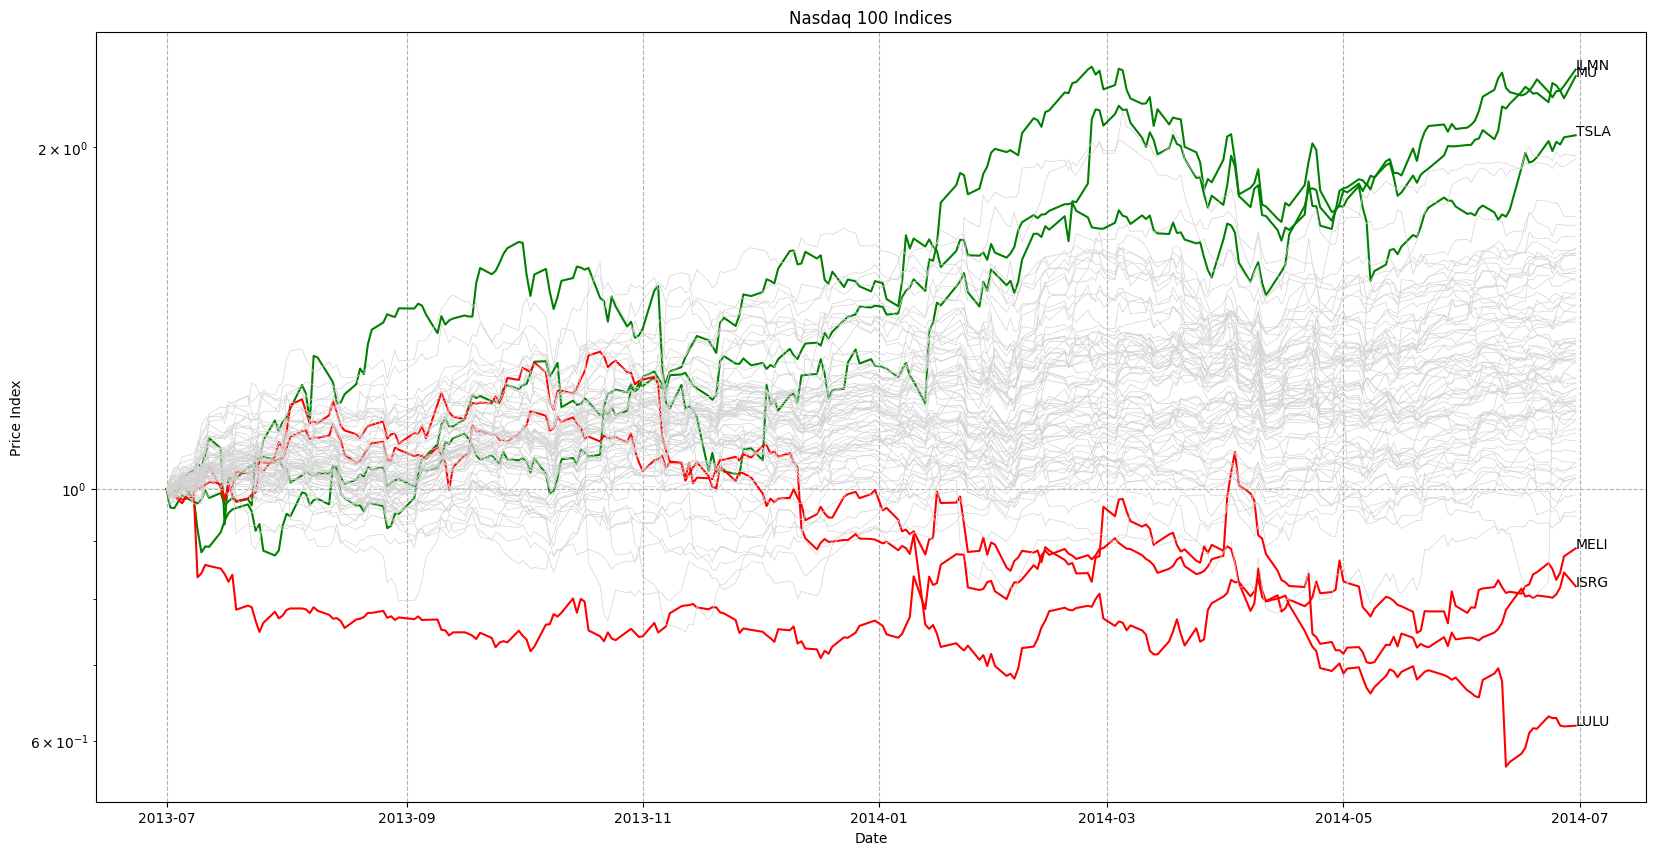

            Price   ShareCount
Ticker                        
LULU    40.480000  8234.519197
ISRG    45.755554  7285.090065
MELI    94.176788  3539.442566
             Price    ShareCount
Ticker                          
ILMN    178.539993   1866.995328
MU       32.435734  10276.731689
TSLA     16.004000  20828.126679


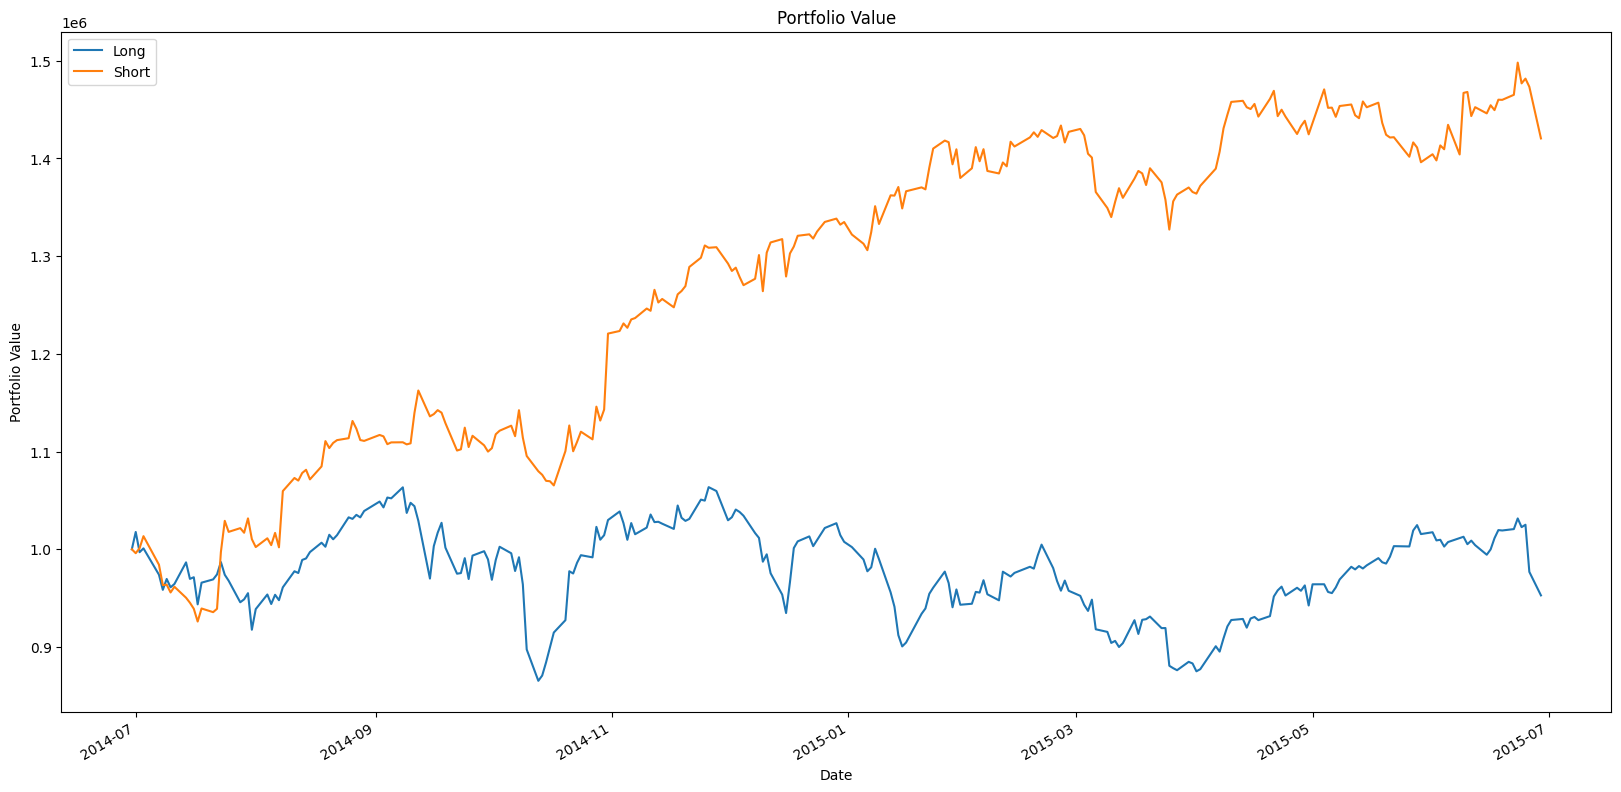

In [97]:
signal_start_date = '2013-07-01'
numPositions = 3
signal_months = 12
trading_months = 12

signalDT, signalIndexDT, signal_start_date, signal_end_date = get_signal_data(hPricesDT, signal_start_date, signal_months)
topPerformers, bottomPerformers, otherPerformers = get_top_bottom_tickers(signalDT, signalIndexDT, numPositions)
plot_signal_period(signalDT, topPerformers, bottomPerformers, otherPerformers)
shortPORT, longPORT = get_long_short_portfolios(signalDT, signal_start_date, 1000000, topPerformers, bottomPerformers, numPositions)
print(shortPORT)
print(longPORT)
longPort_values, shortPort_values = run_portfolio_performance(longPORT, shortPORT, hPricesDT, signal_end_date, trading_months)
plot_portfolio_performance(longPort_values, shortPort_values)
